In [1]:
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import os
%matplotlib notebook
tf.disable_v2_behavior()
print(np.array([['X11','X12','X13','X14'],['X21','X22','X23','X24']]).shape)
posdata = np.stack(([['X11','X12','X13','X14'],['X21','X22','X23','X24']],[['NN11','NN12','NN13','NN14'],['NN21','NN22','NN23','NN24']],[['NNN11','NNN12','NNN13','NNN14'],['NNN21','NNN22','NNN23','NNN24']]),axis=2)
   
posdata=np.reshape(posdata,(2,4*3))
print(posdata)
posdata=np.reshape(posdata[0],(4,3))
print(posdata)

Instructions for updating:
non-resource variables are not supported in the long term
(2, 4)
[['X11' 'NN11' 'NNN11' 'X12' 'NN12' 'NNN12' 'X13' 'NN13' 'NNN13' 'X14'
  'NN14' 'NNN14']
 ['X21' 'NN21' 'NNN21' 'X22' 'NN22' 'NNN22' 'X23' 'NN23' 'NNN23' 'X24'
  'NN24' 'NNN24']]
[['X11' 'NN11' 'NNN11']
 ['X12' 'NN12' 'NNN12']
 ['X13' 'NN13' 'NNN13']
 ['X14' 'NN14' 'NNN14']]


In [2]:
def load_data(file_name,maxrow):
    print("read data from \"",file_name,"\"")
    
    xdata=np.loadtxt(file_name,max_rows=maxrow)
    print(xdata.shape)
    print(np.argwhere(np.isnan(xdata[:,1])))
    xdata=np.delete(xdata,np.argwhere(np.isnan(xdata[:,1])),axis=0)
    maxrow=xdata.shape[0]
    print(xdata.shape)
    L=(xdata.shape[1]-3)//9
    print(L)
    ydata=xdata[:,1]
    dxdata=xdata[:,xdata.shape[1]-1]
    
    posdata=xdata[:,2+4*L:2+5*L]
    NNdata=np.stack((xdata[:,2+L:2+2*L],xdata[:,2+3*L:2+4*L],xdata[:,2+5*L:2+6*L],xdata[:,2+7*L:2+8*L]),axis=2)
    NNNdata=np.stack((xdata[:,2:2+L],xdata[:,2+2*L:2+3*L],xdata[:,2+6*L:2+7*L],xdata[:,2+8*L:2+9*L]),axis=2)
    NNdata=np.mean(NNdata,axis=2)
    NNNdata=np.mean(NNNdata,axis=2)
    
    averagex=np.mean(xdata[:,2:xdata.shape[1]-1])
    print(averagex)
    gdata_append=0.25*(posdata+np.outer(dxdata,np.ones(L))-averagex)**4-averagex**2/2.0*(posdata+np.outer(dxdata,np.ones(L))-averagex)**2-0.25*(posdata-averagex)**4+averagex**2/2.0*(posdata-averagex)**2
    print(np.outer(dxdata,np.ones(L)).shape)
    gdata_append=np.mean(gdata_append,axis=1)
    zdata_append=np.sum((posdata+np.outer(dxdata,np.ones(L)))**2-posdata**2,axis=1)
    print(posdata.shape)
    posdata = np.stack((posdata,NNdata,NNNdata),axis=2)
   
    posdata=np.reshape(posdata,(maxrow,L*3))
    
    return posdata, dxdata, ydata, zdata_append, gdata_append


def load_data2(file_name,maxrow):
    print("read data from \"",file_name,"\"")
    
    xdata=np.loadtxt(file_name,max_rows=maxrow)
    L=(xdata.shape[1]-3)//9
    print(L)
    ydata=xdata[:,1]
    dxdata=xdata[:,xdata.shape[1]-1]
    
    posdata=xdata[:,2+8*L:2+9*L]
    NNdata=np.stack((xdata[:,2+L:2+2*L],xdata[:,2+3*L:2+4*L],xdata[:,2+4*L:2+5*L],xdata[:,2+6*L:2+7*L]),axis=2)
    NNNdata=np.stack((xdata[:,2:2+L],xdata[:,2+2*L:2+3*L],xdata[:,2+5*L:2+6*L],xdata[:,2+7*L:2+8*L]),axis=2)
    NNdata=np.mean(NNdata,axis=2)
    NNNdata=np.mean(NNNdata,axis=2)
    
    averagex=np.mean(xdata[:,2:xdata.shape[1]-1])
    print(averagex)
    gdata_append=0.25*(posdata+np.outer(dxdata,np.ones(L))-averagex)**4-averagex**2/2.0*(posdata+np.outer(dxdata,np.ones(L))-averagex)**2-0.25*(posdata-averagex)**4+averagex**2/2.0*(posdata-averagex)**2
    print(np.outer(dxdata,np.ones(L)).shape)
    gdata_append=np.mean(gdata_append,axis=1)
    zdata_append=np.sum((posdata+np.outer(dxdata,np.ones(L)))**2-posdata**2,axis=1)
    print(posdata.shape)
    posdata = np.stack((posdata,NNdata,NNNdata),axis=2)
   
    posdata=np.reshape(posdata,(maxrow,L*3))
    
    return posdata, dxdata, ydata, zdata_append, gdata_append



def scaled_data(xdata):
    xdata_mean=np.mean(xdata,axis=0)
    xdata_std=np.std(xdata,axis=0)
    xdata_scaled= (xdata-xdata_mean)/xdata_std
    return xdata_scaled, xdata_mean, xdata_std


def get_next_batch(x,y,start,end):
    x_batch=x[start:end,0:x.shape[1]-3]
    dx_batch=x[start:end,x.shape[1]-3]
    z_batch=x[start:end,x.shape[1]-2]
    g_batch=x[start:end,x.shape[1]-1]
    y_batch=y[start:end]
    return x_batch, dx_batch, z_batch, g_batch, y_batch


def weight_variable(name, shape):
    initer=tf.truncated_normal_initializer(stddev=0.02)
    return tf.get_variable('W_'+name, dtype=tf.float32,shape=shape,initializer=initer)

def bias_variable(name, shape):
    initial=tf.constant(0.0,shape=shape,dtype=tf.float32)
    return tf.get_variable('b_'+name,dtype=tf.float32,initializer=initial)

def create_new_conv_layer(input_data, deltax, num_filters, filter_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], 1, num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 3, 1, 1],padding='VALID')

    # add the bias
    out_layer += bias
    
    # add the theta term
    in_dim=dx.get_shape()[1]
    theta = tf.Variable(tf.truncated_normal([in_dim,num_filters]), name=name+'_theta')
    out_layer +=tf.tensordot(tf.tensordot(tf.squeeze(dx),tf.ones([12],tf.float32),axes=0),theta,axes=0)

    # apply a sigmoid non-linear activation
    out_layer = tf.nn.softplus(out_layer)

    
    return out_layer, weights, bias, theta





def fc_layer(x,num_units,name,activation):
    in_dim=x.get_shape()[1]
    W=weight_variable(name,shape=[in_dim,num_units])
    b=bias_variable(name,[num_units])
    layer=tf.matmul(x,W)
    layer+=b
    if activation=='softplus':
        layer=tf.nn.tanh(layer)
    elif activation=='sigmoid':
        layer=tf.nn.tanh(layer)
    return layer, W, b

def fc_layer_final(x,g,z,num_units,name):
    in_dim=x.get_shape()[1]
    W1=weight_variable(name,shape=[in_dim,num_units])
    W2g=weight_variable(name+'g',shape=[1,num_units])
    W3z=weight_variable(name+'x',shape=[1,num_units])
    b=bias_variable(name,[num_units])
    
    layer=tf.matmul(x,W1)+tf.matmul(g,W2g)+tf.matmul(z,W3z)

    layer+=b
    return layer, W1, W2g, W3z, b

def save_data(file_name,name,x,matrix):
    out_file=open(file_name,'a')
    if matrix:
        out_file.write("%30s: [  %4d  ,  %4d  ]\n"%(name,x.shape[0], x.shape[1]))
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                out_file.write("%10.6f    " %(x[i,j]))
            out_file.write("\n")
    else:
        out_file.write("%s: [  %4d  ]\n"%(name,x.shape[0]))
        for i in range(x.shape[0]):
            out_file.write("%10.6f    "%(x[i]))
        out_file.write("\n")
    out_file.close()

In [3]:
# set parameters
file_name="./traindata/build/globaltrain.dat"
#file_name="./Desktop/block_train0003.dat"

maxrow=100000

# set hyper parameters
epochs=400
batch_size=100
display_freq=50
learning_rate=0.0005
L2_regularization=0.0000

In [4]:
# read in data
xdata, dxdata, ydata, zdata_append, gdata_append=load_data(file_name,maxrow)
#xdata, dxdata, ydata, zdata_append, gdata_append=load_data2(file_name,maxrow)

# scaled data
xdata_scaled,        xdata_mean,        xdata_std        = scaled_data(xdata)
zdata_append_scaled, zdata_append_mean, zdata_append_std = scaled_data(zdata_append)
gdata_append_scaled, gdata_append_mean, gdata_append_std = scaled_data(gdata_append)
dxdata_scaled,       dxdata_mean,       dxdata_std       = scaled_data(dxdata)
xdata_combined=np.concatenate((xdata_scaled,np.array([dxdata_scaled]).T,np.array([zdata_append_scaled]).T,np.array([gdata_append_scaled]).T),axis=1)

# split data
x_train, x_test, y_train, y_test = train_test_split(xdata_combined, ydata, test_size=0.33, random_state=42)
L = (x_train.shape[1]-3)//3
print("Size of:")
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t{}'.format(x_test.shape))
print('y_test:\t{}'.format(y_test.shape))

read data from " ./traindata/build/globaltrain.dat "
(100000, 372)
[[ 1858]
 [ 2102]
 [ 3883]
 [ 4593]
 [ 6848]
 [ 7661]
 [10873]
 [11204]
 [11641]
 [11676]
 [13452]
 [20589]
 [32514]
 [33842]
 [34666]
 [34670]
 [34671]
 [34675]
 [34676]
 [45141]
 [46334]
 [50403]
 [52522]
 [52611]
 [53808]
 [54427]
 [58048]
 [60096]
 [62789]
 [63246]
 [64427]
 [69353]
 [70425]
 [71789]
 [72850]
 [73937]
 [78008]
 [79561]
 [86044]
 [87830]
 [88963]
 [95384]
 [96311]
 [98784]]
(99956, 372)
41
-3.9996732015947853
(99956, 41)
(99956, 41)
Size of:
x_train:	(66970, 126)
y_train:	(66970,)
x_test:	(32986, 126)
y_test:	(32986,)


In [5]:
#create placeholders
x = tf.placeholder(tf.float32,shape=[None, x_train.shape[1]-3],name='X')
x_shaped = tf.reshape(x,[-1,L,3,1])
dx = tf.placeholder(tf.float32,shape=[None, 1] ,name='dX')
g = tf.placeholder(tf.float32,shape=[None, 1] ,name='g')
z = tf.placeholder(tf.float32,shape=[None, 1] ,name='z')
y = tf.placeholder(tf.float32,shape=[None,1] ,name='Y')

#define the network
convout, Wconv, bconv, thetaconv = create_new_conv_layer(x_shaped, dx, 10, [8,3], name="convlayer")
print_convout = tf.Print(convout,[convout],"The shape of convout: ")
flattened = tf.reshape(print_convout, [-1, 10*((L-8)//3+1)])
fc1, W1, b1 = fc_layer(flattened, 20 , 'FC1' , 'sigmoid')
fcib, Wib, bib = fc_layer(fc1, 10 , 'FCib' , 'sigmoid')

output, W2, W2g, W2z, b2 = fc_layer_final(fcib,g,z,1,'FC2')


loss=tf.reduce_mean(tf.squared_difference(output, y))
regularizer=tf.reduce_sum([tf.nn.l2_loss(W1), tf.nn.l2_loss(W2), tf.nn.l2_loss(W2g), tf.nn.l2_loss(W2z), tf.nn.l2_loss(Wconv), tf.nn.l2_loss(thetaconv)])
total_loss=tf.reduce_sum(loss+L2_regularization*regularizer)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate,name="Adam_op").minimize(total_loss)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [ ]:
# initializing all variables
init=tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)
num_tr_iter=int(len(y_train)/batch_size)
print('num_tr_iter = ', num_tr_iter)
store_loss_train_name='global_loss_train.dat'
sltn=open(store_loss_train_name,"w+")

for epoch in range(epochs):
    print('-----------------------------------------------')
    print('Training epoch : ', epoch)
    print('-----------------------------------------------')
    perm = np.arange(y_train.shape[0])
    np.random.shuffle(perm)
    y_train = y_train[perm]
    x_train = x_train[perm]
    for iteration in range(num_tr_iter):
        
        start=iteration*batch_size
        end=(iteration+1)*batch_size
        x_batch,dx_batch,z_batch,g_batch,y_batch=get_next_batch(x_train,y_train,start,end)
        z_batch=np.expand_dims(z_batch,1)
        dx_batch=np.expand_dims(dx_batch,1)
        g_batch=np.expand_dims(g_batch,1)
        y_batch=np.expand_dims(y_batch,1)

        feed_dict_batch={x:x_batch,dx:dx_batch,g:g_batch,z:z_batch,y:y_batch}

        sess.run(optimizer,feed_dict=feed_dict_batch)

        if iteration%display_freq==0:
            loss_batch=sess.run(loss,feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Loss = {1:2f}".format(iteration,loss_batch))
            sltn.write("%6d    %15.12f\n" %(iteration+epoch*num_tr_iter, loss_batch))
sltn.close()



num_tr_iter =  669
-----------------------------------------------
Training epoch :  0
-----------------------------------------------
iter   0:	 Loss = 0.708223
iter  50:	 Loss = 0.598177
iter 100:	 Loss = 0.305611
iter 150:	 Loss = 0.358333
iter 200:	 Loss = 0.348044
iter 250:	 Loss = 0.327364
iter 300:	 Loss = 0.170087
iter 350:	 Loss = 0.152237
iter 400:	 Loss = 0.159348
iter 450:	 Loss = 0.128239
iter 500:	 Loss = 0.162145
iter 550:	 Loss = 0.135288
iter 600:	 Loss = 0.085323
iter 650:	 Loss = 0.092525
-----------------------------------------------
Training epoch :  1
-----------------------------------------------
iter   0:	 Loss = 0.116794
iter  50:	 Loss = 0.099569
iter 100:	 Loss = 0.113833
iter 150:	 Loss = 0.108555
iter 200:	 Loss = 0.137771
iter 250:	 Loss = 0.099111
iter 300:	 Loss = 0.088824
iter 350:	 Loss = 0.109633
iter 400:	 Loss = 0.061434
iter 450:	 Loss = 0.080191
iter 500:	 Loss = 0.101608
iter 550:	 Loss = 0.104129
iter 600:	 Loss = 0.124394
iter 650:	 Loss = 0.

iter 300:	 Loss = 0.004034
iter 350:	 Loss = 0.008907
iter 400:	 Loss = 0.002443
iter 450:	 Loss = 0.002889
iter 500:	 Loss = 0.004507
iter 550:	 Loss = 0.004750
iter 600:	 Loss = 0.005364
iter 650:	 Loss = 0.005514
-----------------------------------------------
Training epoch :  17
-----------------------------------------------
iter   0:	 Loss = 0.002078
iter  50:	 Loss = 0.002764
iter 100:	 Loss = 0.002676
iter 150:	 Loss = 0.005090
iter 200:	 Loss = 0.002804
iter 250:	 Loss = 0.002209
iter 300:	 Loss = 0.003456
iter 350:	 Loss = 0.006267
iter 400:	 Loss = 0.011904
iter 450:	 Loss = 0.001959
iter 500:	 Loss = 0.003084
iter 550:	 Loss = 0.005789
iter 600:	 Loss = 0.007477
iter 650:	 Loss = 0.001893
-----------------------------------------------
Training epoch :  18
-----------------------------------------------
iter   0:	 Loss = 0.002937
iter  50:	 Loss = 0.002477
iter 100:	 Loss = 0.003703
iter 150:	 Loss = 0.003934
iter 200:	 Loss = 0.005341
iter 250:	 Loss = 0.011851
iter 300:	

iter  50:	 Loss = 0.002007
iter 100:	 Loss = 0.002528
iter 150:	 Loss = 0.003610
iter 200:	 Loss = 0.005941
iter 250:	 Loss = 0.002600
iter 300:	 Loss = 0.003778
iter 350:	 Loss = 0.002354
iter 400:	 Loss = 0.004352
iter 450:	 Loss = 0.002175
iter 500:	 Loss = 0.002479
iter 550:	 Loss = 0.003779
iter 600:	 Loss = 0.002819
iter 650:	 Loss = 0.002501
-----------------------------------------------
Training epoch :  34
-----------------------------------------------
iter   0:	 Loss = 0.001872
iter  50:	 Loss = 0.009364
iter 100:	 Loss = 0.003877
iter 150:	 Loss = 0.003590
iter 200:	 Loss = 0.002121
iter 250:	 Loss = 0.002301
iter 300:	 Loss = 0.014069
iter 350:	 Loss = 0.002864
iter 400:	 Loss = 0.004815
iter 450:	 Loss = 0.001718
iter 500:	 Loss = 0.006445
iter 550:	 Loss = 0.003678
iter 600:	 Loss = 0.003157
iter 650:	 Loss = 0.005312
-----------------------------------------------
Training epoch :  35
-----------------------------------------------
iter   0:	 Loss = 0.001902
iter  50:	

iter 600:	 Loss = 0.003440
iter 650:	 Loss = 0.002166
-----------------------------------------------
Training epoch :  50
-----------------------------------------------
iter   0:	 Loss = 0.003277


<IPython.core.display.Javascript object>


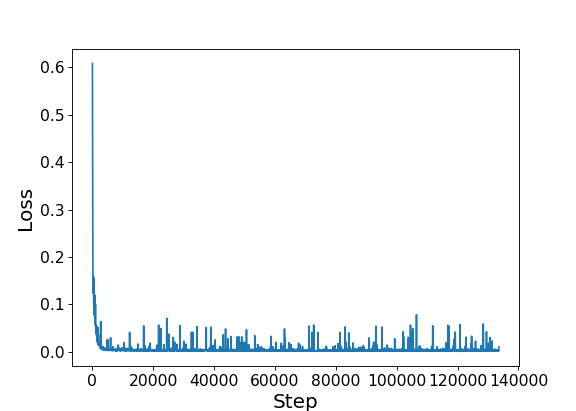

<IPython.core.display.Javascript object>


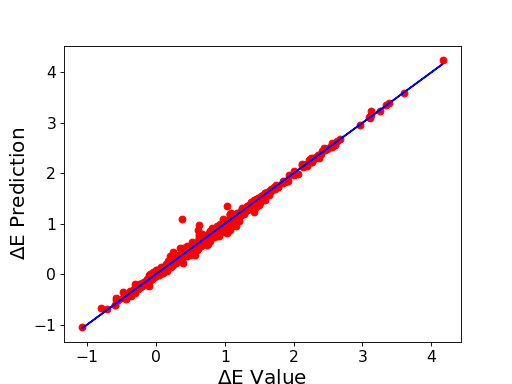

(1000, 1)


In [13]:
# plot training loss function
#matplotlib.figure.Figure()
xloss,yloss=np.loadtxt(store_loss_train_name,unpack=True)
plt.plot(xloss, yloss)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Step',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.show()

plt.figure()
# save and plot y_predict_train, y_train
store_y_train_name='y_train.dat'
sytn=open(store_y_train_name,"w+")
np.random.seed(68721)
random_list=np.random.randint(len(y_train),size=2000)
x_batch=np.zeros([1000,x_train.shape[1]-3])
g_batch=np.zeros([1000,1])
dx_batch=np.zeros([1000,1])
z_batch=np.zeros([1000,1])
y_batch=np.zeros([1000,1])
for i in range(1000):
    x_batch[i,0:x_train.shape[1]-3]=x_train[random_list[i],0:x_train.shape[1]-3].T
    g_batch[i,0]=x_train[random_list[i],x_train.shape[1]-1]
    z_batch[i,0]=x_train[random_list[i],x_train.shape[1]-2]
    dx_batch[i,0]=x_train[random_list[i],x_train.shape[1]-3]
    y_batch[i,0]=y_train[random_list[i]]

feed_dict_batch={x:x_batch,dx:dx_batch,g:g_batch,z:z_batch,y:y_batch}
y_train_predict=sess.run(output,feed_dict=feed_dict_batch)
print(y_train_predict.shape)
for i in range(1000):
    sytn.write("%15.12f    %15.12f\n" %(y_batch[i,0], y_train_predict[i,0]))
sytn.close()

#matplotlib.figure.Figure()
y1, y2=np.loadtxt(store_y_train_name,unpack=True)
plt.plot(y1, y2,'ro')
plt.plot(y1,y1,'-b')
plt.xlabel('$\Delta$E Value',fontsize=18)
plt.ylabel('$\Delta$E Prediction',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [8]:
x_batch,dx_batch,z_batch,g_batch,y_batch=get_next_batch(x_test,y_test,0,len(y_test))
dx_batch=np.expand_dims(dx_batch,1)
y_batch=np.expand_dims(y_batch,1)
g_batch=np.expand_dims(g_batch,1)
z_batch=np.expand_dims(z_batch,1)

feed_dict_batch={x:x_batch,dx:dx_batch,g:g_batch,z:z_batch,y:y_batch}
loss_test=sess.run(loss,feed_dict=feed_dict_batch)
print("Test Loss = ",loss_test,"\n")


Test Loss =  0.0037318014 



In [18]:
print("variable list:\n")
print(tf.trainable_variables())
W_conv_ = [v for v in tf.trainable_variables() if v.name == "convlayer_W:0"][0]
b_conv_ = [v for v in tf.trainable_variables() if v.name == "convlayer_b:0"][0]
t_conv_ = [v for v in tf.trainable_variables() if v.name == "convlayer_theta:0"][0]

W_FC1_ = [v for v in tf.trainable_variables() if v.name == "W_FC1:0"][0]
b_FC1_ = [v for v in tf.trainable_variables() if v.name == "b_FC1:0"][0]
W_FC2_ = [v for v in tf.trainable_variables() if v.name == "W_FC2:0"][0]
W_FC2g_ = [v for v in tf.trainable_variables() if v.name == "W_FC2g:0"][0]
W_FC2z_ = [v for v in tf.trainable_variables() if v.name == "W_FC2x:0"][0]
b_FC2_ = [v for v in tf.trainable_variables() if v.name == "b_FC2:0"][0]

W_conv=W_conv_.eval(session=sess)
b_conv=b_conv_.eval(session=sess)
t_conv=t_conv_.eval(session=sess)

W_FC1=W_FC1_.eval(session=sess)
b_FC1=b_FC1_.eval(session=sess)
W_FC2=W_FC2_.eval(session=sess)
b_FC2=b_FC2_.eval(session=sess)
W_FC2g=W_FC2g_.eval(session=sess)
W_FC2z=W_FC2z_.eval(session=sess)




variable list:

[<tf.Variable 'convlayer_W:0' shape=(8, 3, 1, 10) dtype=float32_ref>, <tf.Variable 'convlayer_b:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'convlayer_theta:0' shape=(1, 10) dtype=float32_ref>, <tf.Variable 'W_FC1:0' shape=(120, 20) dtype=float32_ref>, <tf.Variable 'b_FC1:0' shape=(20,) dtype=float32_ref>, <tf.Variable 'W_FC2:0' shape=(20, 1) dtype=float32_ref>, <tf.Variable 'W_FC2g:0' shape=(1, 1) dtype=float32_ref>, <tf.Variable 'W_FC2x:0' shape=(1, 1) dtype=float32_ref>, <tf.Variable 'b_FC2:0' shape=(1,) dtype=float32_ref>]


In [41]:
print(gdata_append_mean)

83.62579378382638


In [20]:
print(b_FC2)

[-0.18434961]


In [43]:
output_file_name="L41global_hyper_parameter.dat"
if os.path.exists(output_file_name):
    os.remove(output_file_name)
f = open(output_file_name, "a")
for i in range(10):
    for j in range(8):
        for k in range(3):
            f.write(str(W_conv[j,k,0,i])+' ')
f.write('\n')
for i in range(120):
    for j in range(20):
        f.write(str(W_FC1[i,j])+' ')
    f.write('\n')
for j in range(20):
    f.write(str(W_FC2[j,0])+' ')
f.write('\n')
f.write(str(W_FC2g[0,0])+' ')
f.write('\n')
f.write(str(W_FC2z[0,0])+' ')
f.write('\n')
for j in range(10):
    f.write(str(t_conv[0,j])+' ')
f.write('\n')
for j in range(10):
    f.write(str(b_conv[j])+' ')
f.write('\n')
for j in range(20):
    f.write(str(b_FC1[j])+' ')
f.write('\n')
f.write(str(b_FC2[0])+' ')
f.write('\n')
for i in range(123):
    f.write(str(xdata_mean[i])+' ')
f.write('\n')
for i in range(123):
    f.write(str(xdata_std[i])+' ')
f.write('\n')
f.write(str(dxdata_mean)+' ')
f.write('\n')
f.write(str(dxdata_std)+' ')
f.write('\n')
f.write(str(zdata_append_mean)+' ')
f.write('\n')
f.write(str(zdata_append_std)+' ')
f.write('\n')
f.write(str(gdata_append_mean)+' ')
f.write('\n')
f.write(str(gdata_append_std)+' ')
f.write('\n')
f.close()